In [78]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [91]:
N, n = 21, 6
A, b = np.zeros((n, n), dtype=float), np.full(n, fill_value=N, dtype=float)

for i in range(n):
    for j in range(n):
        c = 0.1 * N * (i + 1) * (j + 1)
        A[i, j] = 1000 / (3*c**2 + c**3)

x = np.linalg.solve(A, b)
cond_value = np.linalg.cond(A, p=np.inf)
print(f"Решение системы {x=}, Число обусловленности = {cond_value}")

Решение системы x=array([ 5.83328395e+05, -1.28347866e+08,  2.87812060e+09, -1.71784680e+10,
        3.55160291e+10, -2.30797857e+10]), Число обусловленности = 3749057141917.2344


In [80]:
delta = 0.05
d = np.empty(n)
for i in range(n):
    b_i = b.copy()
    b_i[i] += delta
    x_i = np.linalg.solve(A, b_i)
    d[i] = np.linalg.norm(x - x_i, ord=np.inf) / np.linalg.norm(x, ord=np.inf)

print(f"Вектор относительных погрешностей {d=}")


Вектор относительных погрешностей d=array([6.07655693e-07, 1.43070054e-04, 3.29189476e-03, 1.99160852e-02,
       4.15215031e-02, 2.71358027e-02])


Компонента b 21.0, оказывающая наибольшее влияние, имеет индекс 4


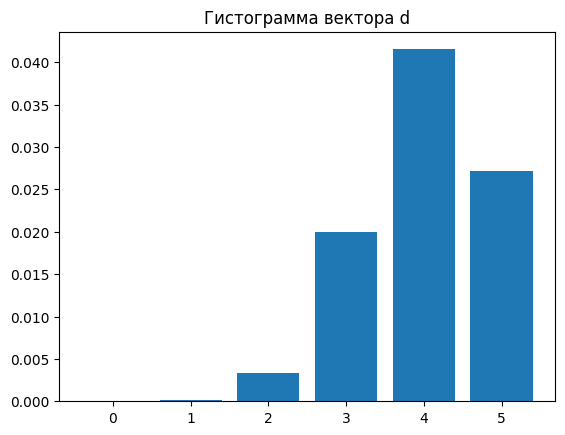

In [81]:
plt.bar(np.arange(0, n), d)
plt.title("Гистограмма вектора d")
print(f"Компонента b {b[np.argmax(d)]}, оказывающая наибольшее влияние, имеет индекс {np.argmax(d)}")

In [92]:
for i in range(n):
    b_i = b.copy()
    b_i[i] += delta

    estimation = cond_value * (np.linalg.norm(b - b_i, ord=np.inf) / np.linalg.norm(b, ord=np.inf))
    print(f"x{i}: Погрешность detla(xi): {d[i]}, Оцененная погрешность delta(xi): {estimation}")

x0: Погрешность detla(xi): 6.076556930291947e-07, Оцененная погрешность delta(xi): 8926326528.374495
x1: Погрешность detla(xi): 0.00014307005358855097, Оцененная погрешность delta(xi): 8926326528.374495
x2: Погрешность detla(xi): 0.0032918947563169328, Оцененная погрешность delta(xi): 8926326528.374495
x3: Погрешность detla(xi): 0.01991608515744848, Оцененная погрешность delta(xi): 8926326528.374495
x4: Погрешность detla(xi): 0.04152150313758436, Оцененная погрешность delta(xi): 8926326528.374495
x5: Погрешность detla(xi): 0.027135802719507645, Оцененная погрешность delta(xi): 8926326528.374495


In [83]:
import pandas as pd

n, m = 25, 10

def cholesky(A: np.ndarray, n: int) -> np.ndarray:
    L = np.zeros((n,n))

    for j in range(n):
        for i in range(n):
            if j < i:
                sum = np.dot(L[i,:], L[j,:])
                multiplier = 1/L[j,j]
                sum = 0 if np.isnan(sum) or np.isinf(sum) else sum
                multiplier = 1 if np.isnan(multiplier) or np.isinf(multiplier) else multiplier

                L[i,j] = multiplier * (A[i,j] - sum)
            if i == j:
                sum = np.sum(L[i,:i]**2)
                sum = 0 if np.isnan(sum) or np.isinf(sum) else sum

                L[i,j] = np.sqrt(A[i,i] - sum)
    return L

/tmp/ipykernel_79346/625091022.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [84]:
A = np.empty((n,n))
b = np.arange(n)**2 - n

for i in range(n):
    for j in range(n):
        if i == j:
            A[i,j] = n + m**2 + j/m + i/n
        else:
            A[i,j] = (i+j)/(m+n)

L = cholesky(A,n)
A_tmp = L.dot(L.transpose())   # Проверка решения
print(np.allclose(A, A_tmp))
pd.DataFrame(L).to_csv('lmatrix.csv')
pd.DataFrame(L.transpose()).to_csv('lmatrix.csv')

True


In [85]:
y = np.linalg.solve(L, b)
x = np.linalg.solve(L.transpose(), y)
print(x)

[-0.3326762  -0.33098052 -0.31330826 -0.27969114 -0.23016078 -0.16474871
 -0.08348641  0.01359477  0.12646352  0.25508864  0.39943901  0.55948358
  0.73519138  0.92653154  1.13347326  1.35598581  1.59403856  1.84760094
  2.11664249  2.4011328   2.70104155  3.0163385   3.3469935   3.69297646
  4.05425737]


In [86]:
def value_to_decimal(value, m):
    return int(value * 10 ** m + 0.5) / 10 ** m

In [87]:
def gauss_partial_sle(A, b):
    n = len(b)
    M = np.hstack((A, b.reshape(-1, 1)))
    # Прямой ход
    for k in range(n):
        # Выбор главной строки по столбцу
        max_index = k + np.argmax(np.abs(M[k:,k]))
        M[k], M[max_index] = M[max_index].copy(), M[k].copy()

        for i in range(k+1, n):
            modifier = M[i, k] / M[k, k]
            M[i, :] -= M[k, :] * modifier

    # Обратный ход
    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        multiplier = 1 / M[i,i]
        sum = np.dot(M[i,i+1:n], x[i+1:])
        x[i] = multiplier * (M[i, -1] - sum)
    return x

In [88]:
def gauss_partial_sle_rounded(A, b):
    n = len(b)
    M = np.hstack((A, b.reshape(-1, 1)))
    for k in range(n):
        max_index = k + np.argmax(np.abs(M[k:,k]))
        M[k], M[max_index] = M[max_index].copy(), M[k].copy()

        for i in range(k+1, n):
            modifier = value_to_decimal(M[i, k] / M[k, k], m)
            M[i, :] -= M[k, :] * modifier
            M[i, :] = np.array([value_to_decimal(v, m) for v in M[i, :]])

    x = np.zeros(n)
    for i in range(n-1, -1, -1):
        multiplier = value_to_decimal(1 / M[i,i], m)
        sum = np.dot(M[i,i+1:n], x[i+1:])
        x[i] = value_to_decimal(multiplier * (M[i, -1] - sum), m)
    return x

In [89]:
def generate_sle(t):
    qm = 0.993 + (-1)**M * M * 10 ** -4

    A = np.empty((n,n))
    b = qm**(n+1-np.arange(n))
    for i in range(n):
        for j in range(n):
            q_j = qm ** j
            if i == j:
                A[i,j] = q_j + t
            else:
                A[i,j] = q_j
    return A, b


def generate_sle_rounding(t):
    qm = np.round(0.993 + np.round((-1)**M * M * 10 ** -4, m),m)

    A = np.empty((n,n))
    b = np.round(qm**(n+1-np.arange(n)),m)
    for i in range(n):
        for j in range(n):
            q_j = np.round(qm ** j, m)
            if i == j:
                A[i,j] = np.round(q_j + np.round(t,m))
            else:
                A[i,j] = q_j
    return A, b


In [90]:
M, N, n, m = 5, 5, 45, 4
T = [0.0001, 1, 10000]

for t in T:
    A1, b1 = generate_sle(t)
    A2, b2 = generate_sle_rounding(t)
    x1 = gauss_partial_sle(A1, b1)
    x2 = gauss_partial_sle_rounded(A2,b2)
    discrepancy1 = b2 - A2.dot(x2)
    print(f"t: {t}; Решение системы {x1=}")
    print(f"t: {t}; Решение системы {x2=}")
    print(f"t: {t}; Норма разности решений: {np.linalg.norm(x1 - x2)}, Норма неувязки второго решения: {np.linalg.norm(discrepancy1)}")
    print()

t: 0.0001; Решение системы x1=array([-1234.25290944, -1180.80454033, -1126.95227926, -1072.69307416,
       -1018.02384987,  -962.94150801,  -907.4429268 ,  -851.52496084,
        -795.18444098,  -738.41817412,  -681.22294303,  -623.59550616,
        -565.53259748,  -507.03092626,  -448.08717693,  -388.69800883,
        -328.86005608,  -268.56992737,  -207.82420575,  -146.61944845,
         -84.95218669,   -22.81892546,    39.78385662,   102.8597076 ,
         166.41220228,   230.44494251,   294.96155736,   359.9657033 ,
         425.46106444,   491.45135275,   557.94030823,   624.93169914,
         692.42932222,   760.4370029 ,   828.95859554,   897.99798358,
         967.55907984,  1037.6458267 ,  1108.26219634,  1179.41219094,
        1251.09984292,  1323.3292152 ,  1396.10440138,  1469.42952599,
        1543.30874474])
t: 0.0001; Решение системы x2=array([-30.4121,   0.7067,   0.7181,   0.7265,   0.7273,   0.7344,
         0.7398,   0.7466,   0.7517,   0.7573,   0.7628,   0.7686,
 